# Rossmann Sales Forecasting Model

Author: Sam Steinberg, Computer Science Graduate Student, Arizona State University


    The purpose of this project is to forecast Rossmann sales, a german drug store chain, over the course of the upcoming months and years. Goal is to build a forecasting model that has a mean absolute percentage error under 20%.

## Step 1- Data Preprocessing & Exploration

In [451]:
# Loading Libraries
import pandas as pd #Dataset Manipulation
import numpy as np #Math
import seaborn as sns #Graphing library
import matplotlib.pyplot as plt #Visualization
import matplotlib.style as style
#style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
#Dataset Source: https://www.kaggle.com/c/rossmann-store-sales/data?select=test.csv

In [452]:
# Loading Datasets
df1 = pd.read_csv('store.csv')
print(df1.info())
df2 = pd.read_csv('train.csv')
print(df2.info())
df3 = pd.read_csv('test.csv')
print(df3.info())
dfs = [df1,df2,df3]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open          

In [453]:
# Getting number of null values in each column
for i in dfs:
    print(i.isnull().sum(axis = 0))

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64
Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64


In [454]:
# Getting rid of rows with NA values for "Competition Distance" and "Open" columns
df3 = df3[df3['Open'].notna()]
df1 = df1[df1['CompetitionDistance'].notna()]
df1.isnull().sum(axis = 0)

# Dropping columns from df1 who have a significant amount of NA values
df1 = df1.dropna(axis = 1)

In [455]:
# No NA values remain in any of the three datasets
dfs = [df1,df2,df3]
for i in dfs:
    print(i.isnull().sum(axis = 0))

Store                  0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
dtype: int64
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64
Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


In [456]:
# Getting rid of rows at end that have "0's" as data
df2Reduced = df2[0:1016095]

### Variable Exploration

We need to sum up the total sales from each store location per day (from df2) in order for this to be time series data

In [457]:
df2TimeSeries = df2Reduced.groupby(["Date"]).sum()

We now have 941 days of time series data that include the revenue and number of customers!

Grouping data by store type:

In [458]:
df1Mod = df1.groupby(["StoreType"], axis = 0).sum()
print(df1Mod)

            Store  CompetitionDistance  Promo2
StoreType                                     
a          336216            3078960.0     289
b            9545              18030.0       5
c           90006             521340.0      75
d          184611            2391920.0     201


Insights:
- There are "a" and "b" store types
- "b" stores are close to their competition


Text(0, 0.5, 'Sales')

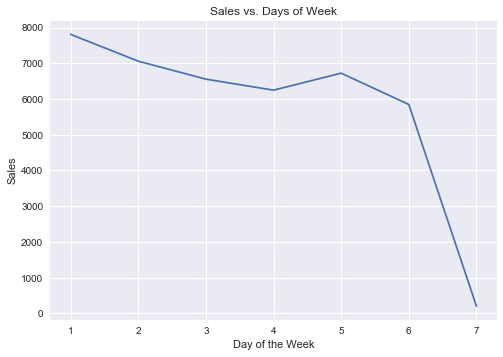

In [459]:
df = df2Reduced
df = df.groupby("DayOfWeek").mean()
plt.plot(df["Sales"])
plt.title('Sales vs. Days of Week')
plt.xlabel("Day of the Week")
plt.ylabel('Sales')

Sales and number of customers have been significantly lower on Sundays, indicating the drug store could save money by closing on Sundays. 

## Step 2- Preparing Data for Time Series Analysis

Removing categorical variables and removing rows with outliers or unrecorded sales

In [460]:
df2TS = df2TimeSeries.drop(['Customers','Store','DayOfWeek','Open','Promo','SchoolHoliday'], axis = 1)

Grouping Data by Week since we only have 2-3 years worth of data:

In [461]:
df2TS.index = pd.to_datetime(df2TS.index)
df2TS = df2TS.groupby(pd.Grouper(freq='7D')).sum()
pd.set_option('display.max_rows', 10)

#Deleting remainder data (last row) since it will be an outlier
df2TS = df2TS[:-1]

print(df2TS)

               Sales
Date                
2013-01-02  45608385
2013-01-09  41098316
2013-01-16  40059749
2013-01-23  40290176
2013-01-30  46309914
...              ...
2015-06-24  49305462
2015-07-01  46223374
2015-07-08  47639457
2015-07-15  45522550
2015-07-22  45528677

[134 rows x 1 columns]


25858872


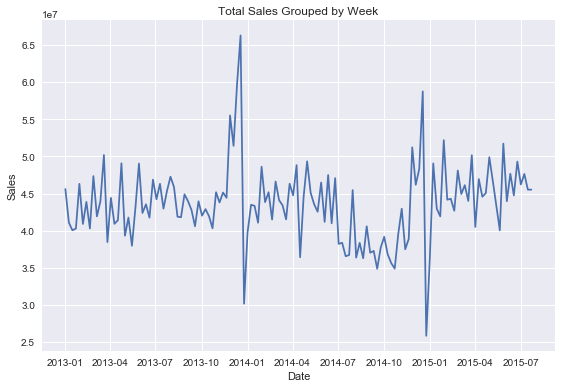

In [462]:
plt.style.use('seaborn')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Total Sales Grouped by Week')
plt.tight_layout()
plt.plot(df2TS['Sales'])
print(df2TS['Sales'].min())

Data has a pattern, appears seasonal. 

Removing rows with outliers (includes rows with no sales):

In [463]:
#df2TS.drop(df2TS[df2TS['Sales'] > 230000000].index, inplace = True)
df2TS.drop(df2TS[df2TS['Sales'] == 0].index, inplace = True)
#df2TS.sort_values(by = ['Sales'], ascending = [True])
print("Min Value: " + str(df2TS['Sales'].min()))
print("Max Value: " + str(df2TS['Sales'].max()))

Min Value: 25858872
Max Value: 66276652


Determining Rolling Statistic to check stationarity  of data:

In [464]:
rolmean = df2TS['Sales'].rolling(window = 7).mean() #31 months in dataset
rolstd = df2TS['Sales'].rolling(window = 7).std()
print(rolmean, rolstd)

Date
2013-01-02             NaN
2013-01-09             NaN
2013-01-16             NaN
2013-01-23             NaN
2013-01-30             NaN
                  ...     
2015-06-24    4.582523e+07
2015-07-01    4.624051e+07
2015-07-08    4.732510e+07
2015-07-15    4.643999e+07
2015-07-22    4.666342e+07
Freq: 7D, Name: Sales, Length: 134, dtype: float64 Date
2013-01-02             NaN
2013-01-09             NaN
2013-01-16             NaN
2013-01-23             NaN
2013-01-30             NaN
                  ...     
2015-06-24    3.969380e+06
2015-07-01    3.812114e+06
2015-07-08    2.663325e+06
2015-07-15    1.871927e+06
2015-07-22    1.600972e+06
Freq: 7D, Name: Sales, Length: 134, dtype: float64


Plotting rolling statistics to determine if data is stationary:

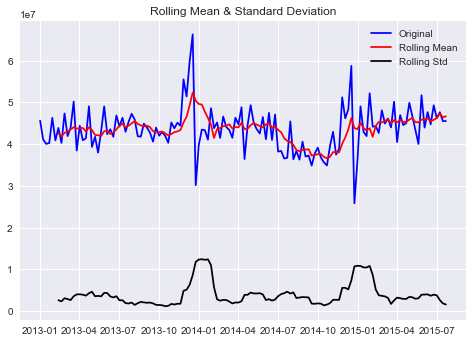

In [465]:
orig = plt.plot(df2TS['Sales'], color = 'blue', label = 'Original')
mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

It appears our data is stationary since their is no obvious trend in the above graph. We will perform further tests to confirm. 

Performing Dickey-Fuller Test:
- H0: Data is not stationary
- H1: Data is stationary

In [466]:
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test: ')
dftest = adfuller(df2TS['Sales'], autolag = 'AIC')

dfoutput = pd.Series(dftest[0:4], index = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Vaue (%s) '%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test: 
ADF Test Statistic              -4.634702
p-value                          0.000111
#Lags Used                       2.000000
Number of Observations Used    131.000000
Critical Vaue (1%)              -3.481282
Critical Vaue (5%)              -2.883868
Critical Vaue (10%)             -2.578677
dtype: float64


Since our p-value is below common significance levels of 0.05 and 0.01, and since two of the critical values are greater than the test statistic, we can reject the null hypothesis and say this data is stationary. This means we can now run a forecasting model on it to predict future sales. 

## Step 4- Forecasting Sales

In [467]:
from fbprophet import Prophet
df2TS['date_time'] = df2TS.index.strftime("%Y-%m-%d")
dfP= df2TS.rename(columns={'date_time': 'ds', 'Sales': 'y'})
pModel = Prophet(interval_width=0.90)
pModel.fit(dfP)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [468]:
df_forecast = pModel.make_future_dataframe(periods=52, freq='W') #Best is 52
df_forecast = pModel.predict(df_forecast)

<Figure size 1296x288 with 0 Axes>

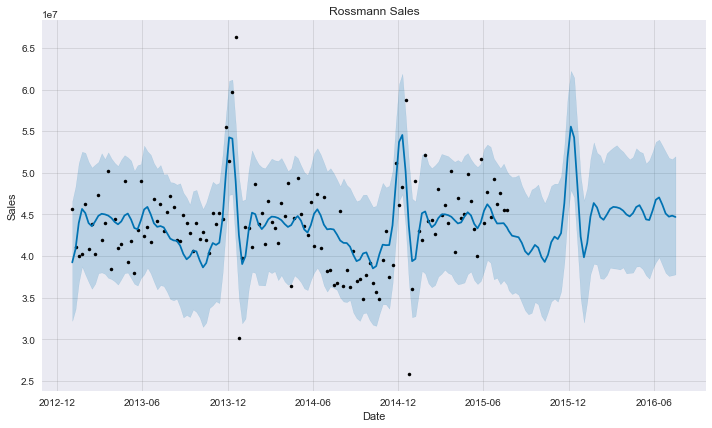

In [469]:
plt.figure(figsize=(18, 4))
pModel.plot(df_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Rossmann Sales');

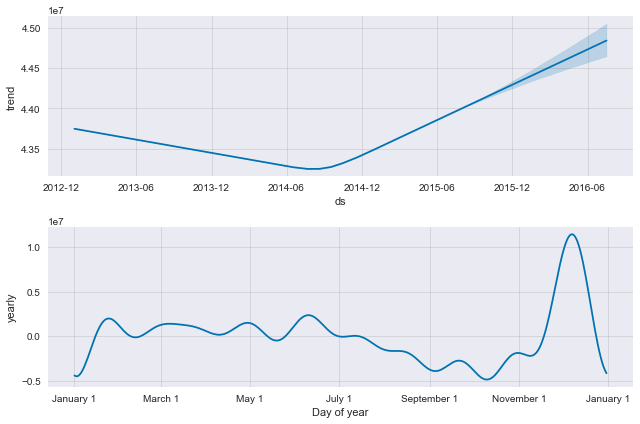

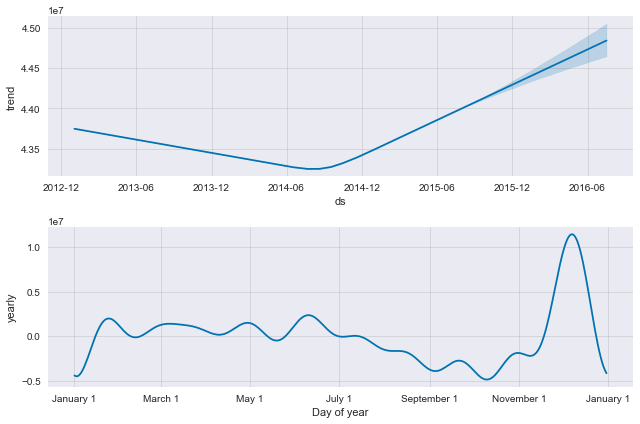

In [470]:
pModel.plot_components(df_forecast)

Charts reveal: 
- Sales rapidly increase around the holiday season then decrease at the beginning of the year. Sales stay constant through spring and summer, but steadily decrease in the fall until the next holiday season. 
- Sales are steadily increasing as the year go by 

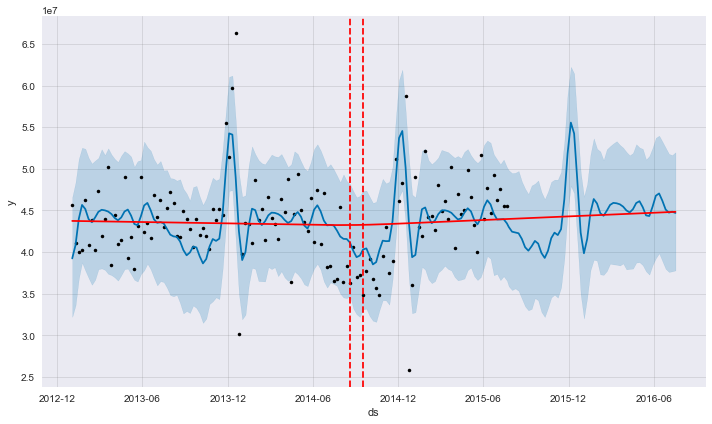

In [471]:
from fbprophet.plot import add_changepoints_to_plot
fig = pModel.plot(df_forecast)
a = add_changepoints_to_plot(plt.gca(), pModel, df_forecast)

We can see a changepoint occur right before the holiday season, indicating holidays have a strong impact on sales, further validating this claim. 

In [472]:
from fbprophet.diagnostics import cross_validation
cv_results = cross_validation(pModel, initial = '105 W', period = '52 W', horizon = '10 W') #20, 52, 50

INFO:fbprophet:Making 1 forecasts with cutoffs between 2015-05-13 00:00:00 and 2015-05-13 00:00:00


In [473]:
#Calculating MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_baseline = mean_absolute_percentage_error(cv_results.y, cv_results.yhat)
print('MAPE: ' + str(mape_baseline))

MAPE: 9.448151483676812


Our MAPE is 9.44%. This is a very good score, as the cutoff for a respectable score is 20%. The cutoff for an excellent score is 10%. Hence, this forecasting model is very accurate. 

## Conclussion

- Rossmann does not receive many customers on Sundays, indicating they might make more profit by closing on that day
- Data is seasonal, sales increase during the holiday season. They then drop off at the beginning of the year, increase through spring and start to decline at the beginnning of July
- Sales steadily increasing since the end of 2013, expected to continue into 2016 with a confidence interval of 95%
- Model predicted sales with only a 9.44% error